In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

TODO:

1. pose question
2. address data cleaning/missing values
3. exploratory data analysis
4. permutation/hypothesis test
5. base model (will only use basic training-test split)
6. final model (cross-validation, hyperparameter stuff) * SEE LECTURE 16, 17
7. fairness analysis (optional)
8. conclusions - address question

# **Modeling Medical Insurance Costs**

## Source

This data was found on kaggle here: https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download \
Thanks to Mr. M Rahul Vyas for uploading the dataset to kaggle. \
The data is licensed by MIT.

## **Questions**

Which features influence medical costs the most? \
How accurately machine learning models predict medical insurance charges?

## **Data Cleaning/Missing Values**

Luckily, this data was already cleaned for us. There are also no missing values in our dataset.

In [2]:
insurance_raw = pd.read_csv(r"C:\Users\ritac\Downloads\medical_insurance\medical_insurance.csv")
insurance_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


## **Exploratory Data Analysis**

Here we will do exploratory data analysis, helping us conduct our hypothesis testing and model building better.

### Age

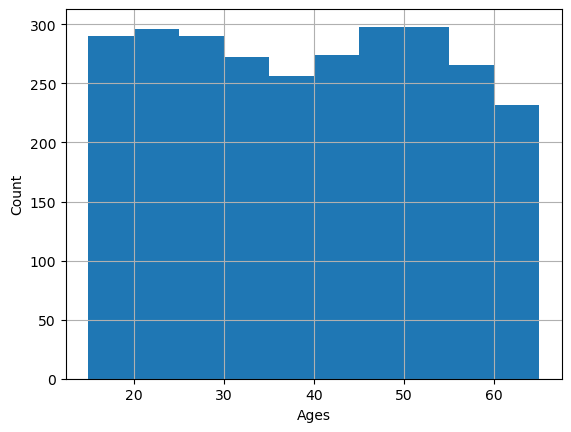

In [23]:
plt.hist(insurance_raw['age'], bins=np.arange(15, 70, 5))
plt.xlabel('Ages')
plt.ylabel('Count')
plt.grid()
plt.show()

We can see that our dataset does not have values for children and most teenagers, or for seniors. It's important to note this as this means our model will only be able to make predictions for people within this age range.

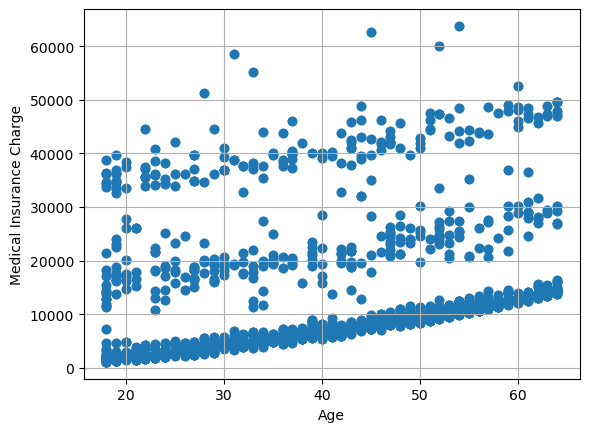

In [4]:
plt.scatter(insurance_raw['age'], insurance_raw['charges'])
plt.xlabel('Age')
plt.ylabel('Medical Insurance Charge')
plt.grid()
plt.show()

We can see that it seems that there are 3 clusters of points. A clear line can be seen at the bottom of the dataset, consisting of assuming to be healthy individuals since they have the lowest charges. Then there's an unhealthier group, with their line in the middle, and an ever unhealthier group, with their line at the top. But the general trend can be seen that as age increases, charges increase.

### BMI

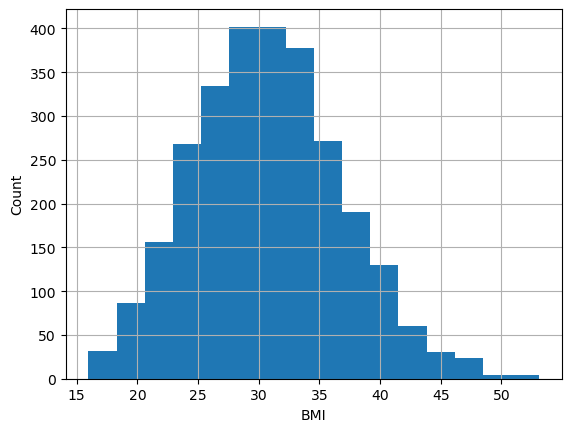

In [5]:
plt.hist(insurance_raw['bmi'], bins=16)
plt.xlabel('BMI')
plt.ylabel('Count')
plt.grid()
plt.show()

The BMI's of our dataset is approximately Normally distributed. Thus our model should not overfit to a certain group. Since it represents people from all BMI levels,  it could be used to make predictions from people of all BMI levels.

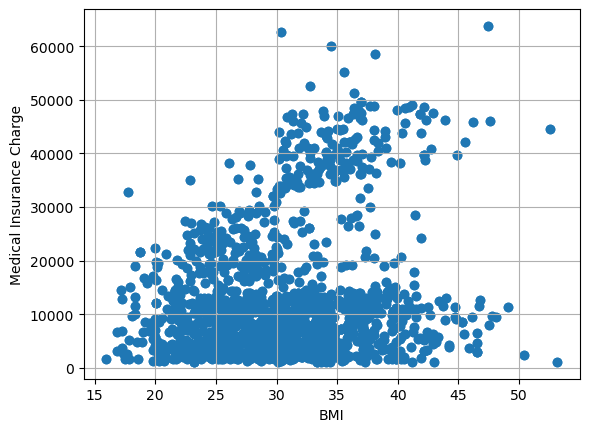

In [6]:
plt.scatter(insurance_raw['bmi'], insurance_raw['charges'])
plt.xlabel('BMI')
plt.ylabel('Medical Insurance Charge')
plt.grid()
plt.show()

There seems to be no linear relationship between BMI and medical insurance charges. For some of the dataset, it looks like there's a positive linear assocation between the two, but if you look at it in its totality it appears there's no association.

### Sex

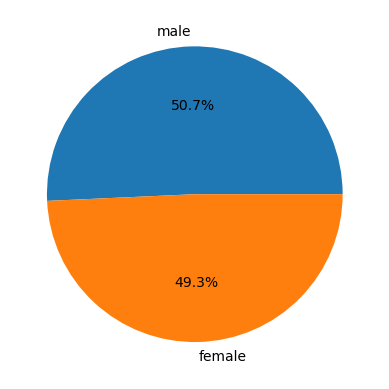

In [7]:
sex_counts = insurance_raw['sex'].value_counts()
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%')
plt.show()

There's approximately an equal amount of male and females in the dataset, so our model should be able to make predictions for both sexes.

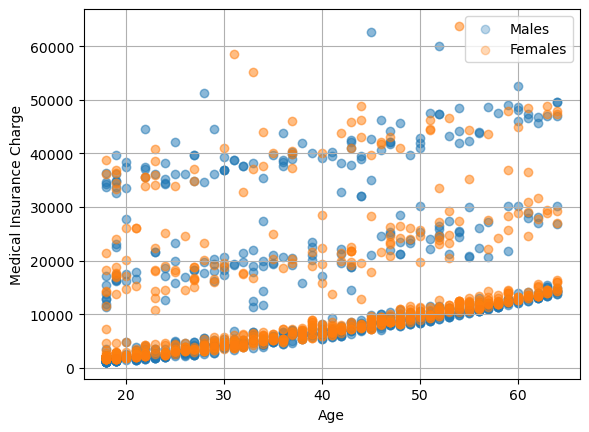

In [31]:
males = insurance_raw[insurance_raw['sex'] == 'male']
females = insurance_raw[insurance_raw['sex'] == 'female']
plt.scatter(males['age'], males['charges'], label='Males', alpha=0.3)
plt.scatter(females['age'], females['charges'], label='Females', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Medical Insurance Charge')
plt.grid()
plt.legend()
plt.show()

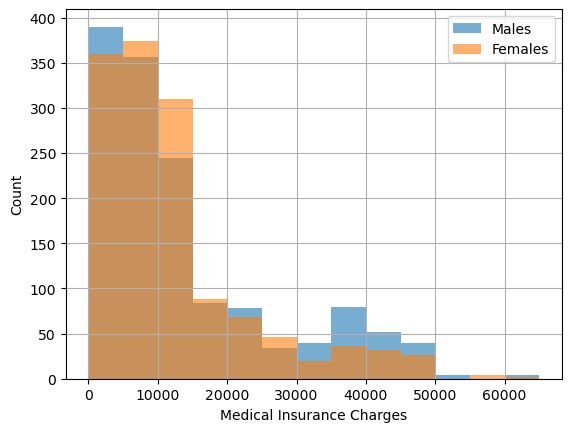

In [26]:
plt.hist(males['charges'], label='Males', alpha=0.6, bins=np.arange(0, 70000, 5000))
plt.hist(females['charges'], label='Females', alpha=0.6, bins=np.arange(0, 70000, 5000))
plt.xlabel('Medical Insurance Charges')
plt.ylabel('Count')
plt.grid()
plt.legend()
plt.show()

If we separate our dataset into males and females, and then compare age with medical insurance charges, it appears gender has no effect on the charges.

### Children

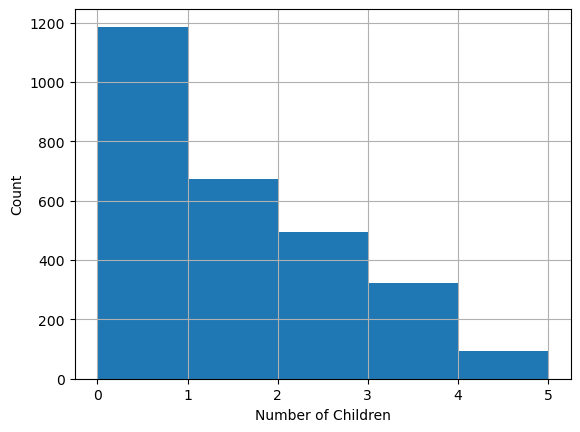

In [10]:
plt.hist(insurance_raw['children'], bins=np.arange(0, 6, 1))
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.grid()
plt.show()

Our dataset represents people with different types of children, so should be accurate in given predictions with such. However for making predictions for people with more children, it may be less accurate since our training data is right skewed. However this reflects the reality of the population.

### Smoker

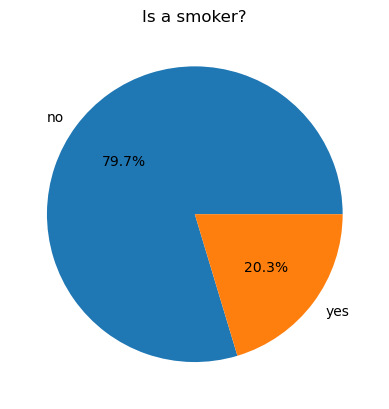

In [24]:
smoker_counts = insurance_raw['smoker'].value_counts()
plt.pie(smoker_counts, labels=smoker_counts.index, autopct='%1.1f%%')
plt.title('Is a smoker?')
plt.show()

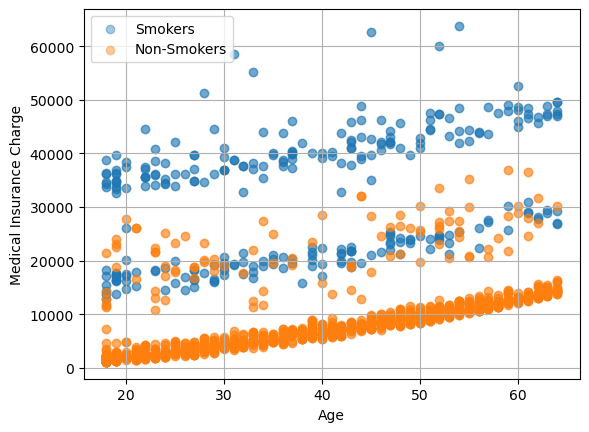

In [44]:
smokers = insurance_raw[insurance_raw['smoker'] == 'yes']
non_smokers = insurance_raw[insurance_raw['smoker'] == 'no']
plt.scatter(smokers['age'], smokers['charges'], label='Smokers', alpha=0.4)
plt.scatter(non_smokers['age'], non_smokers['charges'], label='Non-Smokers', alpha=0.4)
plt.xlabel('Age')
plt.ylabel('Medical Insurance Charge')
plt.grid()
plt.legend()
plt.show()

There are enough smokers and non-smokers in our dataset to which our model will be accurate for both.

It also appears that most of the non-smokers are in the main line at the bottom, and the smokers are at the top. It appears non-smokers have much lower medical insurance charges than smokers.

### Region

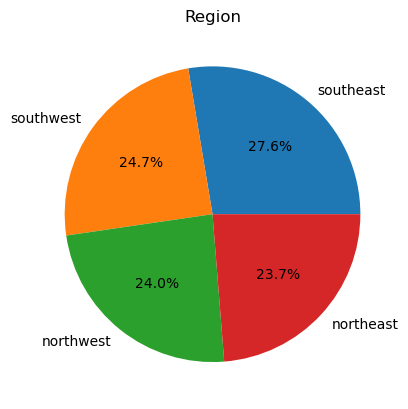

In [25]:
region_counts = insurance_raw['region'].value_counts()
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%')
plt.title('Region')
plt.show()

There's about an equal number of people in each region, so our model should be accurate for all regions.

## **Base Model**


### Feature Engineering

We first split our data into a training and test set, as standard.

Then, we will need to convert the 'sex', 'smoker', and 'region' features into quantitative features for our model to work. We will use one-hot encoding for this. \

Rest numerical features are standardized, allowing us to directly compare the weights to determine the most important feature.

In [13]:
X = insurance_raw.drop('charges', axis=1)
y = insurance_raw['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

preproc = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first'), categorical_features),
    ('standardize', StandardScaler(), numerical_features)
])

base_model = Pipeline([
    ('preprocessing', preproc),
    ('base_model', LinearRegression())
])

base_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('base_model', LinearRegression())])

In [32]:
R_squared_base = base_model.score(X_test, y_test)
R_squared_base

0.6777204551781524

In [15]:
RMSE_base = mean_squared_error(y_test, base_model.predict(X_test), squared=False)
RMSE_base

6517.0573053117605

### Base Model Analysis

Our R^2 for this model is 0.67, and the RMSE is 6517. This is not horrible, but it's also not great.

In [34]:
base_model.named_steps['base_model'].coef_

array([  137.1863813 , 24256.60161046,  -109.76671036,  -811.58699881,
        -724.97621988,  3679.86967152,  2065.84020019,   504.41003682])

In [40]:
ohe_feature_names = preproc.named_transformers_['ohe'].get_feature_names_out(categorical_features)
all_feature_names = ohe_feature_names.tolist() + numerical_features
coefficients = base_model.named_steps['base_model'].coef_

# Combine feature names and coefficients
feature_coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})
feature_coefficients



,Feature,Coefficient
0,sex_male,137.186381
1,smoker_yes,24256.601610
2,region_northwest,-109.766710
3,region_southeast,-811.586999
4,region_southwest,-724.976220
5,age,3679.869672
6,bmi,2065.840200
7,children,504.410037
